In [2]:
import pandas as pd
from pathlib import Path
from loader import get_subfolders, load_multiple_timings

folders = get_subfolders(Path("../measurements/dielFilterV2real/compare_comb"))
# Returns the matrix name and a dictionary of mapping from function to dataframe
matrix, ft = load_multiple_timings(folders)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# SCALING_FACTOR = 10**9 # for seconds
SCALING_FACTOR = 10**6
plt.rcParams['font.family'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
STYLES = {
    # color, marker, offst, name
    "comb": ('deeppink', 'D', (-80, -20), "\\textsc{CombBLAS}", None),
    "drop_at_once_parallel": ('dodgerblue', 'o', (-120, 10), "\\textsc{Buffered}", None),
    "drop_parallel": ('goldenrod', 'h', (-100, -20), "\\textsc{Ring}", None),
    "drop_parallel_ns": ('brown', 'h', (-140, 40), "\\textsc{Ring (No Shuffling)}", None),
    # "todo3": ('brown', '^', (-210, -135), "\\textsc{Tensor Macro}", 26),
    # "todo4": ('darkcyan', 'H', (-75, -15), "\\textsc{Merged}", None),
    # "todo5": ('darkolivegreen', 's', (-120, -118), "\\textsc{Merged+Blocked}", None),
}

Text(0.5, 1.0, 'Squaring computation on \\texttt{dielFilterV2real}')

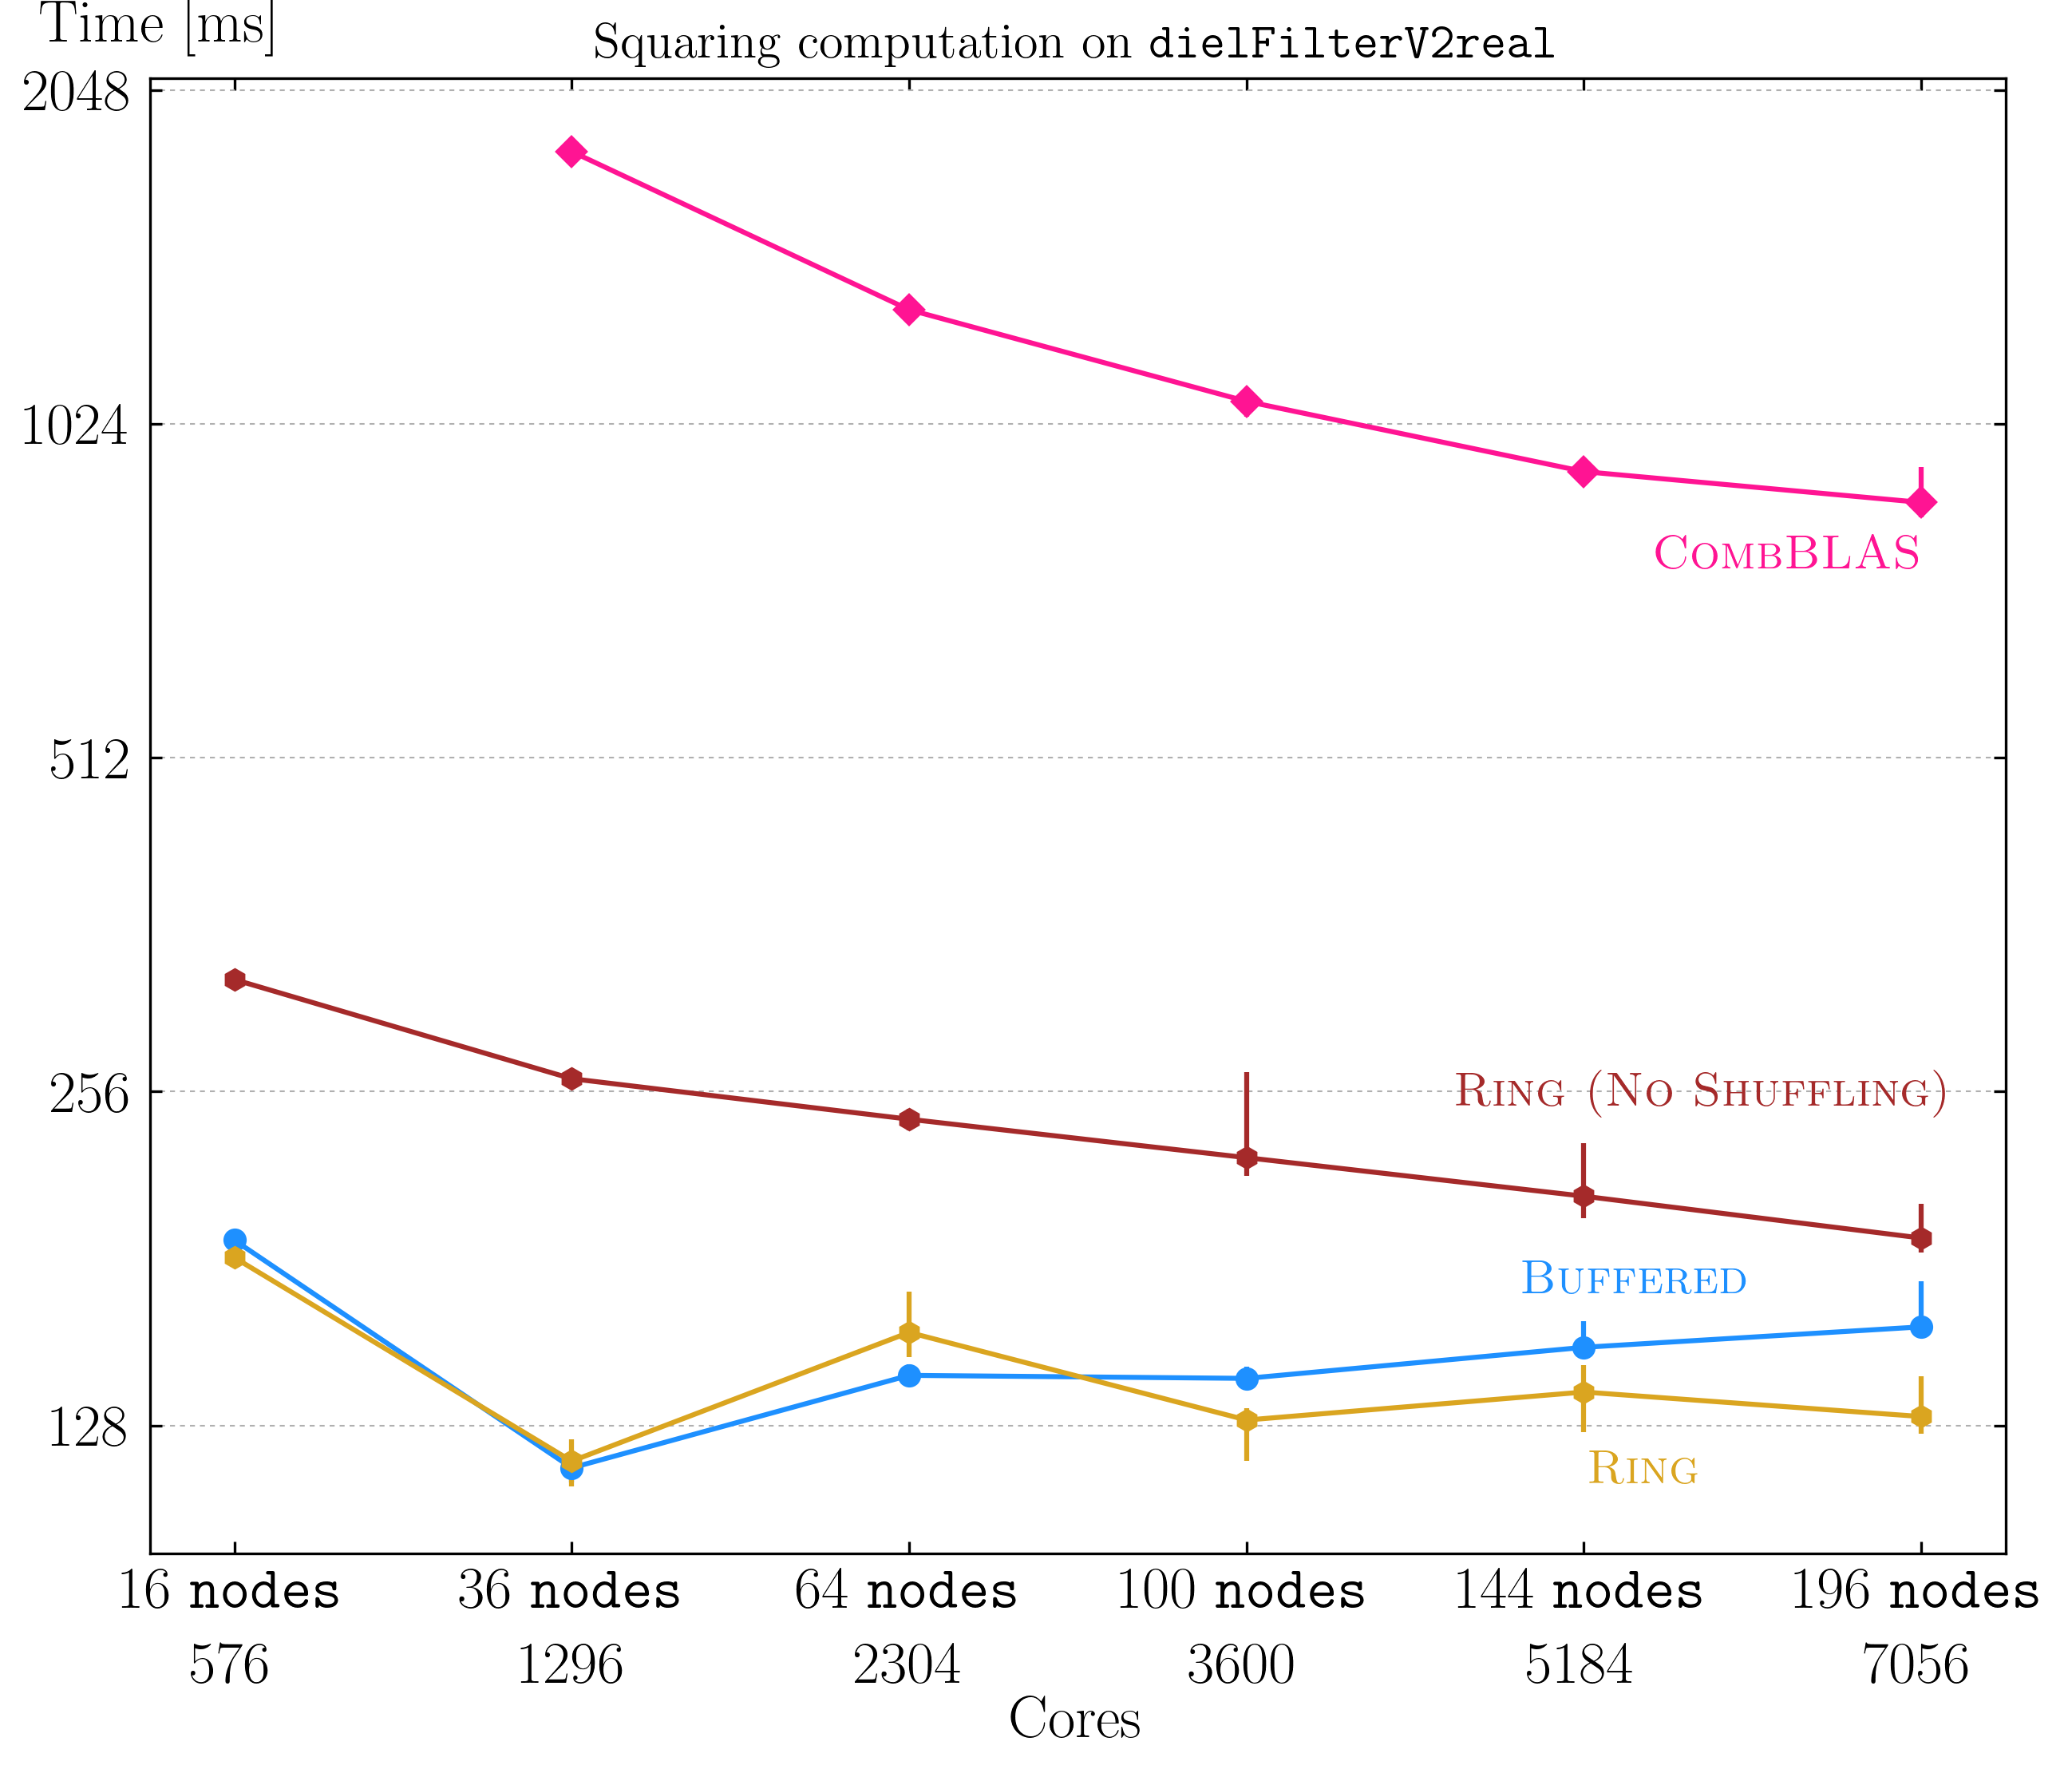

In [16]:
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot()

keysm = {}
keysm[16] = 0
keysm[36] = 1
keysm[64] = 2
keysm[100] = 3
keysm[144] = 4
keysm[196] = 5

for algo, pretty_name in (('comb', 'ComBLAS'), ('drop_at_once_parallel', 'DropAtOnceParallel'), ('drop_parallel', 'DropParallel'), ('drop_parallel_ns', 'DropParallel NS')):
    timings = ft[algo]
    func_data = timings[timings["func"] == 'gemm']

    timings = []
    for key, group in func_data.groupby('mpi'):
        value = group["duration"]
        avg = value.mean()/SCALING_FACTOR
        timings.append({
            "key": key,
            "avg": avg,
            "min": min(value.quantile(0.025)/SCALING_FACTOR, avg),
            "max": max(value.quantile(0.975)/SCALING_FACTOR, avg)
        })

    timings = pd.DataFrame(timings)
    # Calculate the error bars
    eb = [
        (timings['avg'] - timings['min']),
        (timings['max'] - timings['avg'])
    ]

    color, marker, offst, name, rotation = STYLES[algo]

    keys = timings["key"]
    values = timings["avg"]
    ax.annotate(name, (keysm[keys.iloc[-1]], values.iloc[-1]), color=color, xytext=offst, textcoords='offset points', fontsize='x-large', rotation=rotation or 0)
    ax.errorbar([keysm[key] for key in timings["key"]], values, yerr=eb, label=algo, marker=marker, color=color)

    ax.set_xlabel("Cores")
    ax.set_ylabel('Time [ms]',
            rotation='horizontal',
            loc='top')
    ax.yaxis.set_label_coords(0.07, 1.015) 
    ax.set_xticks(range(len(keys)), labels=[f"\\begin{{center}}{mpi}~\\texttt{{nodes}}\\\\{mpi * 36}\\end{{center}}"for mpi in keys])

ax.tick_params(axis='both', direction='in', which='major', pad=5)
ax.grid(which='major', axis='y', linewidth=.5, dashes=(3,3))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.yscale('log', base=2)
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}'))

ax.set_title("Squaring computation on \\texttt{" + matrix + "}", fontsize=15)

In [17]:
fig.savefig("runtime_1.pdf", bbox_inches="tight")